<a href="https://colab.research.google.com/github/ani8alepur/2025-NFL-Big-Data-Bowl/blob/main/ProjectFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Predicting Simulated Pressure based on Pre-Snap Data:**

One of the hottest strategies that defenses are employing in today's game is simulated pressure, commonly known as SimPressure. The idea is fairly simple, yet it can cause havoc for offenses; the defense lines up multiple players near the line of scrimmage, threatening a blitz. However, once the ball is snapped, only some (or in some cases none) of those threatening defenders blitz. The reason SimPressures are so problematic for offenses has a lot to do with the way quarterbacks are coached. When expecting a blitz, quarterbacks typically have a pre-determined read, known as a hot route. This is an easy outlet for the quarterback to throw to when the blitz comes. This is based on the idea that if an extra defender is blitzing, there will be a hole in coverage. In the case of SimPressure, however, there is no hole in coverage, as the threatening defenders aren't really blitzing. This can often lead to those ugly interceptions that make those of us watching at home wonder "What was he thinking? He threw it right to the defender!"

Our goal in this project was to build a model that could take in pre-snap information and use it to predict SimPressures. This could be used as a tool in film study to help predict based on a number of features, or even by play-callers, coaches, and offensive coordinators on the field to assist in their duties.

In [ ]:
import pandas as pd
import numpy as np
import math
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, classification_report, recall_score
from sklearn.tree import plot_tree
from imblearn.over_sampling import SMOTENC
import matplotlib.pyplot as plt
import seaborn as sns
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
plays = pd.read_csv("/content/drive/MyDrive/nfl-big-data-bowl-2025/plays.csv")
player_play = pd.read_csv("/content/drive/MyDrive/nfl-big-data-bowl-2025/player_play.csv")
players = pd.read_csv("/content/drive/MyDrive/nfl-big-data-bowl-2025/players.csv")
games = pd.read_csv("/content/drive/MyDrive/nfl-big-data-bowl-2025/games.csv")

**Feature Engineering/Data Extraction**

We'll start by observing the various columns in the plays dataframe, that we believe are relevant to our model. We are curious to distinguish "down to goal" plays, as well as any player motion by the offense. We also care about the passing yards and rushing yards by the offense prior to the play being run, as we want to see if an offense being successful/unsuccessful on the ground or through the air impacts the defense's use of sim pressure.

We also want to look at the score differential for the offense prior to each play. Once again, we want to analyze whether offensive success (or lack thereof) leads to patterns in sim pressure being called.

In [ ]:
training_df = plays[['gameId', 'playId', 'quarter', 'down', 'yardsToGo', 'quarter', 'gameClock', 'preSnapHomeScore', 'absoluteYardlineNumber',
           'offenseFormation', 'receiverAlignment', 'qbKneel', 'pff_passCoverage', 'pff_manZone']]
training_df['ToGoalOrNot'] = np.where(training_df['yardsToGo'] == training_df['absoluteYardlineNumber'], 1, 0)

motion_df = player_play[['gameId', 'playId', 'motionSinceLineset']]
motion_df = motion_df.groupby(['gameId', 'playId'])['motionSinceLineset'].any().reset_index()
training_df = training_df.merge(motion_df, on=['gameId', 'playId'], how='left')
training_df = training_df.rename(columns={'motionSinceLineset': 'PresenceOfMotion'})
training_df = training_df.sort_values(by=['gameId', 'playId'])


training_df['PriorPassingYards'] = ''
training_df['PriorRushingYards'] = ''
training_df['PresenceOfSimPressure'] = ''

<ipython-input-88-fac657697024>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_df['ToGoalOrNot'] = np.where(training_df['yardsToGo'] == training_df['absoluteYardlineNumber'], 1, 0)


In [ ]:
training = pd.read_csv("/content/drive/MyDrive/my_data.csv")
training = training.merge(plays[['gameId', 'playId', 'yardlineNumber', 'yardlineSide', 'yardsGained', 'possessionTeam', 'defensiveTeam']], on=['gameId', 'playId'], how='left')
training['ToGoalOrNot'] = np.where((training['yardlineNumber'] == training['yardsToGo']) & (training['possessionTeam'] != training['yardlineSide']), 1, 0)
training = training.merge(plays[['gameId', 'playId', 'preSnapVisitorScore']], on=['gameId', 'playId'], how='left')
training = training.merge(games[['gameId', 'homeTeamAbbr', 'visitorTeamAbbr']], on=['gameId'], how='left')
#calculate offensive point differential
def calculate_offense_point_differential(row):
    if row['possessionTeam'] == row['homeTeamAbbr']:
        return row['preSnapHomeScore'] - row['preSnapVisitorScore']
    elif row['possessionTeam'] == row['visitorTeamAbbr']:
        return row['preSnapVisitorScore'] - row['preSnapHomeScore']
    else:
        return np.nan  # Handle cases where possessionTeam doesn't match either home or visitor

training['OffensePointDifferential'] = training.apply(calculate_offense_point_differential, axis=1)
training = training.drop(['quarter.1'], axis = 1)

def calculate_true_distance(row):
  if row['possessionTeam'] == row['yardlineSide']:
    return 100 - row['yardlineNumber']
  elif row['possessionTeam'] != row['yardlineSide']:
    return row['yardlineNumber']
  elif row['yardlineNumber'] == 50:
    return 50
  else:
    return np.nan #error case

training['TrueDistance'] = training.apply(calculate_true_distance, axis=1)

training = training.merge(plays[['gameId', 'playId', 'passResult', 'rushLocationType']], on=['gameId', 'playId'], how='left')

# prompt: create 2 new columns called PassYardsGained and RushYardsGained that calculates the pass/rush yards gained by play. both should be independent by team and play. PassYardsGained should be updated if passResult == ‘C’.

# Initialize 'PassYardsGained' and 'RushYardsGained' columns with 0
training['PassYardsGained'] = 0
training['RushYardsGained'] = 0

# Iterate through rows and update based on conditions
for index, row in training.iterrows():
    if row['passResult'] == 'C':
        training.loc[index, 'PassYardsGained'] = row['yardsGained']
    else:
        training.loc[index, 'RushYardsGained'] = row['yardsGained']


In [ ]:
def calculate_prior_yards(df):
  """Calculates the prior passing and rushing yards for each row.

  Args:
    df: The input DataFrame.

  Returns:
    The DataFrame with updated 'PriorPassingYards' and 'PriorRushingYards' columns.
  """
  df['PriorPassingYards'] = 0
  df['PriorRushingYards'] = 0

  for index, row in df.iterrows():
    # Filter previous rows with the same gameId and possessionTeam
    previous_rows = df[(df['gameId'] == row['gameId']) & (df['possessionTeam'] == row['possessionTeam']) & (df.index < index)]

    # Calculate cumulative sum of PassYardsGained and RushYardsGained
    df.loc[index, 'PriorPassingYards'] = previous_rows['PassYardsGained'].sum()
    df.loc[index, 'PriorRushingYards'] = previous_rows['RushYardsGained'].sum()

  return df


training = calculate_prior_yards(training)

In [ ]:
tracking = pd.read_csv("/content/drive/MyDrive/nfl-big-data-bowl-2025/tracking_week_1.csv")

In [ ]:
tracking = tracking.sort_values(by=['gameId', 'playId', 'nflId', 'frameId'])
tracking = tracking.drop(['displayName', 'jerseyNumber'], axis=1)

**Data Cleaning**

We have to drop non-defensive players (except the QB) and add positions to the tracking data for a couple or reasons. For one, it will make the code run significantly faster and save us RAM. Secondly it will be helpful to know the positions of each plaer in the tracking data, as it wasn't included. Even though the QB isn't a defensive player, we kept it at first and then created a separate dataframe just for the QB before getting rid of it from the tracking data.

In [ ]:
def drop_non_defense(df):
  #merge tracking data with player data to get positions
  df = pd.merge(df, players[['nflId', 'position']], on='nflId', how='left')

  #define positions of interest
  defense_positions = ['DE', 'NT', 'SS', 'FS', 'OLB', 'DT', 'CB', 'ILB', 'MLB', 'DB', 'LB', 'QB']

  df = df[df['position'].isin(defense_positions)]

  df = df.drop(columns=['position'])

  return df

tracking = drop_non_defense(tracking)

In [ ]:
#add the positions to tracking
def add_position(df):
  df = pd.merge(df, players[['nflId', 'position']], on='nflId', how='left')
  return df

tracking = add_position(tracking)

QB_tracking = tracking[tracking['position']=='QB']

In [ ]:
#Get rid of QB data from tracking now that we have separate df
tracking = tracking[tracking['position'] != 'QB']

tracking = tracking[tracking['event'].isin(['line_set', 'ball_snap'])]

This step is an extension of our data cleaning and feature engineering processes. We first got rid of non-passing plays. For each play, we want to count the number of defensive linemen and non-defensive linemen inside or close to the tackle box. This is why keeping the QB as a position was useful, because the tackle box is relative to the QB's position, whether that is in shotgun or directly under center. For reference, this is what a tackle box is supposed to look like. A picture is added below.

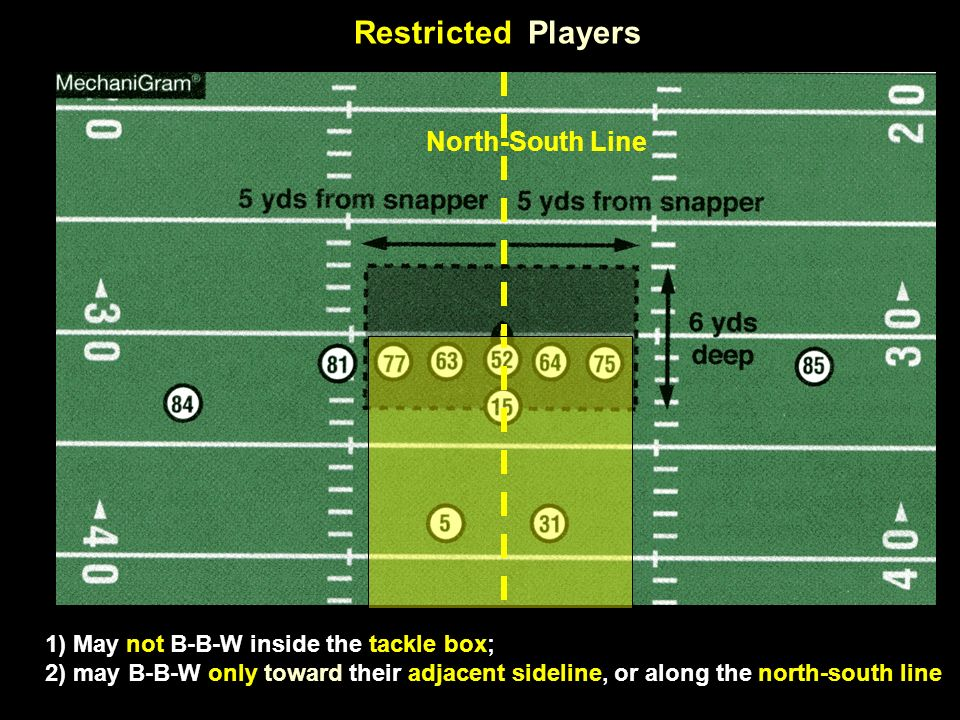

We decided to look a little bit wider (8 yards) and a little bit shallower (3 yards) as we were specifically interested in players who were threatening to rush. We then used the tracking data and the player_play data to see whether the defenders who were threatening to rush indeed rushed the passer or whether they dropped back into covereage. This would reveal to us whether or not there was sim pressure on the play.

In [ ]:
training = training[training['passResult'] != 'NaN']
training['DL_on_LOS'] = 0
training['non_DL_on_LOS'] = 0
training['DL_rushers'] = 0
training['non_DL_rushers'] = 0

In [ ]:
def count_LOS(df):
  DL_positions = ['DE', 'NT', 'DT']
  games_ = tracking['gameId'].unique()
  for g in games_:
    plays_ = tracking[tracking['gameId'] == g]['playId'].unique()
    for p in plays_:
      players_ = tracking[tracking['gameId'] == g][tracking['playId'] == p]['nflId'].unique()
      absolute = df[(df['gameId'] == g) & (df['playId'] == p)]['absoluteYardlineNumber'].values[0]
      for l in players_:
        # Check if QB data exists for the current play and game
        QB_data = QB_tracking[(QB_tracking['gameId'] == g) & (QB_tracking['playId'] == p) & (QB_tracking['position'] == 'QB')]
        if len(QB_data) > 0:
          QB_position = QB_data['y'].values[0]
        else:
          continue  # Skip this play if QB data is missing

        # Check if line_set event data exists for the current player
        line_set_data = tracking[(tracking['gameId'] == g) & (tracking['playId'] == p) & (tracking['nflId'] == l) & (tracking['event'] == 'line_set')]
        if len(line_set_data) > 0:

          if (line_set_data['y'].values[0] >= QB_position - 8) and (line_set_data['y'].values[0] <= QB_position + 8):
            if (line_set_data['x'].values[0] >= absolute - 3) and (line_set_data['x'].values[0] <= absolute + 3):
              if tracking[(tracking['gameId'] == g) & (tracking['playId'] == p) & (tracking['nflId'] == l)]['position'].values[0] in DL_positions:
                df.loc[(df['gameId'] == g) & (df['playId'] == p), 'DL_on_LOS'] += 1
              else:
                df.loc[(df['gameId'] == g) & (df['playId'] == p), 'non_DL_on_LOS'] += 1
        else:
          continue  # Skip this player if 'line_set' event is missing

  return df

  training = count_LOS(training)

In [ ]:
def count_rushers(df):
  DL_positions = ['DE', 'NT', 'DT']
  games_ = tracking['gameId'].unique()
  for g in games_:
    plays_ = tracking[tracking['gameId'] == g]['playId'].unique()
    for p in plays_:
      players_ = tracking[tracking['gameId'] == g][tracking['playId'] == p]['nflId'].unique()
      for l in players_:

        if (not (math.isnan(player_play[player_play['gameId'] == g][player_play['playId'] == p][player_play['nflId'] == l]['getOffTimeAsPassRusher'].values[0]))) and (tracking[tracking['gameId'] == g][tracking['playId'] == p][tracking['nflId'] == l]['position'].values[0] in DL_positions):
          df.loc[(df['gameId'] == g) & (df['playId'] == p), 'DL_rushers'] += 1

        elif (not (math.isnan(player_play[player_play['gameId'] == g][player_play['playId'] == p][player_play['nflId'] == l]['getOffTimeAsPassRusher'].values[0]))) and (tracking[tracking['gameId'] == g][tracking['playId'] == p][tracking['nflId'] == l]['position'].values[0] not in DL_positions):
          df.loc[(df['gameId'] == g) & (df['playId'] == p), 'non_DL_rushers'] += 1
    return df

training = count_rushers(training)

Streaming output truncated to the last 5000 lines.
<ipython-input-98-f0afab2f311c>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  elif (not (math.isnan(player_play[player_play['gameId'] == g][player_play['playId'] == p][player_play['nflId'] == l]['getOffTimeAsPassRusher'].values[0]))) and (tracking[tracking['gameId'] == g][tracking['playId'] == p][tracking['nflId'] == l]['position'].values[0] not in DL_positions):
<ipython-input-98-f0afab2f311c>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if (not (math.isnan(player_play[player_play['gameId'] == g][player_play['playId'] == p][player_play['nflId'] == l]['getOffTimeAsPassRusher'].values[0]))) and (tracking[tracking['gameId'] == g][tracking['playId'] == p][tracking['nflId'] == l]['position'].values[0] in DL_positions):
<ipython-input-98-f0afab2f311c>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if (not (math.isnan(player_play[playe

In [ ]:
def identify_sim_pressure(df):
  for index, row in df.iterrows():
    if (row['DL_on_LOS'] == row['DL_rushers']) and (row['non_DL_on_LOS'] == row['non_DL_rushers']):
      df.loc[index, 'PresenceOfSimPressure'] = 0
    else:
      df.loc[index, 'PresenceOfSimPressure'] = 1
  return df

training = identify_sim_pressure(training)

In [ ]:
#Drop post-snap or unneeded columns

training = training.drop(columns=['DL_rushers'])
training = training.drop(columns=['non_DL_rushers'])
training = training.drop(columns=['DL_on_LOS'])
training = training.drop(columns=['non_DL_on_LOS'])
training = training.drop(columns=['passResult'])
training = training.drop(columns=['rushLocationType'])
training = training.drop(columns=['yardsGained'])
training = training.drop(columns=['gameId'])
training = training.drop(columns=['playId'])
training = training.drop(columns=['homeTeamAbbr'])
training = training.drop(columns=['visitorTeamAbbr'])
training = training.drop(columns=['yardlineSide'])

**Model Building**

As described in the beginning, simulated pressure exists when the not all of the potential QB rushers actually rush the QB. In our final dataset, PresenceOfSimPressure is the outucome variable, and we've set it to be a binary classifier, where 0 indicates no simulated pressure, and 1 indicates simulated pressure. To ensure the smoothest computation as possible and to abide by good data science principles, we dummified variables that served as identifiers for various conditions, such as offensive formation, pass coverage, quarter, and down.

In [ ]:
X = training.drop('PresenceOfSimPressure', axis=1)  # Features (all columns except the target)
y = training['PresenceOfSimPressure']  # Target variable

X = pd.get_dummies(X, columns=['quarter', 'down', 'pff_manZone', 'possessionTeam', 'defensiveTeam', 'offenseFormation', 'receiverAlignment', 'pff_passCoverage'], drop_first=True) # replace with actual non-numeric column names

# Impute NaN values with a placeholder or a more appropriate strategy
training['pff_passCoverage'] = training['pff_passCoverage'].fillna('Unknown')
training['pff_manZone'] = training['pff_manZone'].fillna('Unknown') # Impute NaN values in 'pff_manZone' column
training['offenseFormation'] = training['offenseFormation'].fillna('Unknown') # Impute NaN values in 'offenseFormation' column
training['receiverAlignment'] = training['receiverAlignment'].fillna('Unknown') # Impute NaN values in 'receiverAlignment' column

# Convert 'gameClock' to seconds before splitting into X_train and X_test
def convert_to_seconds(time_str):
  """Converts a time string in the format 'MM:SS' to total seconds."""
  if isinstance(time_str, str):
    minutes, seconds = map(int, time_str.split(':'))
    return minutes * 60 + seconds
  else:
    return time_str  # Or handle as needed (e.g., return 0, raise an error)

training['gameClock'] = training['gameClock'].apply(convert_to_seconds)

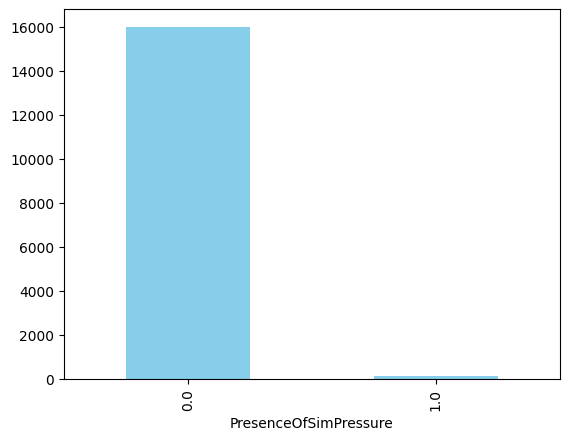

In [ ]:
y.value_counts().plot(kind = 'bar', color = 'skyblue')
plt.show()

From the graph above, we can see an extremely imbalanced dataset, showing that simulated pressure isn't actually acted on when a defense threatens to blitz. To make sure this imbalance doesn't trick our models into predicting no sim pressure when there is sim pressure, we will oversample our data for our models so that the lesser-represented instances can be appropriately predicted. This is why we extracted our categorical columns, as SMOTENC (Synthetic Minority Over-Sampling Technique) asks for it as an input.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

cat_cols = []
for col in X_train.columns:
  if X_train[col].dtype == 'bool':
    cat_cols.append(True)
  else :
    cat_cols.append(False)

In [ ]:
smotenc = SMOTENC(categorical_features = cat_cols, random_state = 42)
X_oversample, y_oversample = smotenc.fit_resample(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


In [ ]:
y_oversample.value_counts()

PresenceOfSimPressure
0.0    12813
1.0    12813
Name: count, dtype: int64

As the last part of our model selection, we decided on a random forest classifer. The reason we decided to use a random forest classifier was because we wanted our model to predict Sim Pressure based on a bunch of features, and using a classifier made sense. The random forest also allows us to analyze which features are particularly important for predicting Sim Pressure, whether it be coverage or certain teams being on offense/defense, etc.

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

rf_classifier.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_val = rf_classifier.predict(X_test)

# Evaluate accuracy on the validation set
rf_normal_report = classification_report(y_test, y_pred_val)
print("Classification report: ", rf_normal_report)

Classification report:                precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3198
         1.0       0.95      0.67      0.78        27

    accuracy                           1.00      3225
   macro avg       0.97      0.83      0.89      3225
weighted avg       1.00      1.00      1.00      3225



We will take time to explain what some of the statistics above mean, as if we had to explain it to someone who doesn't have much knowledge in statistics.

In this case, "recall" is how well our model can identify the instances of simulated pressure. "Precision" is the likelihood of an actual instance being simulated pressure when the model predicts simulated pressure. Since we want high scores for both recall and precision, a good way to check is F1 score, since it's a weighted average of both recall and precision.

Our model above, before adding a new classifier that takes the oversampled data as inputs, has an F1 score of 0.78, which is still quite good for such an imbalanced dataset. From here, it's useful to compare to the oversampled data.

In [ ]:
#look @ oversampled data
rf_os_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

rf_os_classifier.fit(X_oversample, y_oversample)

y_os_pred = rf_os_classifier.predict(X_test)
rf_os_report = classification_report(y_test, y_os_pred)
print("Oversampled classification report: ", rf_os_report)

Oversampled classification report:                precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3198
         1.0       0.96      0.85      0.90        27

    accuracy                           1.00      3225
   macro avg       0.98      0.93      0.95      3225
weighted avg       1.00      1.00      1.00      3225



As expected, we have a higher F1 score for the oversampled data than for the normal observed data. It is still very valuable to look at the oversampled data because it serves as a good way to account for playcalling and scheme variability in future matchups, and hence prevent unforced errors.

In [ ]:
importances = rf_os_classifier.feature_importances_
feature_names = X_train.columns  # Assuming X_train has the feature names

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display or print the DataFrame
feature_importance_df.head(50)

Feature  Importance
40                possessionTeam_LA    0.163862
58                defensiveTeam_BUF    0.150700
27               possessionTeam_BUF    0.120048
71                 defensiveTeam_LA    0.118892
2                  preSnapHomeScore    0.070582
8                 PriorRushingYards    0.049822
10              preSnapVisitorScore    0.043660
24                 pff_manZone_Zone    0.035907
99            receiverAlignment_3x1    0.028763
108        pff_passCoverage_Cover-1    0.022232
7                 PriorPassingYards    0.018422
11         OffensePointDifferential    0.016984
6                  PresenceOfMotion    0.012179
1                         gameClock    0.012146
120       pff_passCoverage_Quarters    0.011688
13                  PassYardsGained    0.011512
0                         yardsToGo    0.010216
3            absoluteYardlineNumber    0.008103
91      offenseFormation_SINGLEBACK    0.007577
20                           down_3    0.007438
19                           down_2    0.007360
9                    yardlineNumber    0.006252
12                     TrueDistance    0.005800
16                        quarter_3    0.004163
96            receiverAlignment_2x1    0.003827
15                        quarter_2    0.003695
110        pff_passCoverage_Cover-2    0.003201
97            receiverAlignment_2x2    0.003095
90         offenseFormation_SHOTGUN    0.003079
17                        quarter_4    0.003007
87          offenseFormation_I_FORM    0.002692
14                  RushYardsGained    0.002438
111        pff_passCoverage_Cover-3    0.002095
115   pff_passCoverage_Cover-3 Seam    0.002041
100           receiverAlignment_3x2    0.001786
106   pff_passCoverage_Cover 6-Left    0.001418
83                 defensiveTeam_SF    0.001214
89          offenseFormation_PISTOL    0.001109
53                possessionTeam_TB    0.001098
84                 defensiveTeam_TB    0.001036
116  pff_passCoverage_Cover-6 Right    0.000977
52                possessionTeam_SF    0.000961
63                defensiveTeam_DAL    0.000926
70                 defensiveTeam_KC    0.000857
22                pff_manZone_Other    0.000785
79                defensiveTeam_NYJ    0.000742
39                possessionTeam_KC    0.000689
57                defensiveTeam_BAL    0.000661
85                defensiveTeam_TEN    0.000629
50               possessionTeam_PIT    0.000566

In [ ]:
importances = rf_classifier.feature_importances_
feature_names = X_train.columns  # Assuming X_train has the feature names

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display or print the DataFrame
feature_importance_df.head(50)

Feature  Importance
40                possessionTeam_LA    0.125792
58                defensiveTeam_BUF    0.123286
71                 defensiveTeam_LA    0.093894
27               possessionTeam_BUF    0.079649
11         OffensePointDifferential    0.060850
10              preSnapVisitorScore    0.056908
7                 PriorPassingYards    0.043847
8                 PriorRushingYards    0.042267
1                         gameClock    0.034549
2                  preSnapHomeScore    0.033838
9                    yardlineNumber    0.030798
3            absoluteYardlineNumber    0.029954
12                     TrueDistance    0.028838
13                  PassYardsGained    0.019577
14                  RushYardsGained    0.015413
6                  PresenceOfMotion    0.013574
0                         yardsToGo    0.013371
110        pff_passCoverage_Cover-2    0.009721
90         offenseFormation_SHOTGUN    0.009228
17                        quarter_4    0.009187
15                        quarter_2    0.008256
16                        quarter_3    0.008238
97            receiverAlignment_2x2    0.007447
115   pff_passCoverage_Cover-3 Seam    0.006728
111        pff_passCoverage_Cover-3    0.006404
19                           down_2    0.005845
91      offenseFormation_SINGLEBACK    0.005374
96            receiverAlignment_2x1    0.004944
100           receiverAlignment_3x2    0.004349
20                           down_3    0.004034
99            receiverAlignment_3x1    0.003956
108        pff_passCoverage_Cover-1    0.003563
102           receiverAlignment_4x1    0.003472
116  pff_passCoverage_Cover-6 Right    0.003471
106   pff_passCoverage_Cover 6-Left    0.003419
83                 defensiveTeam_SF    0.003353
24                 pff_manZone_Zone    0.003293
120       pff_passCoverage_Quarters    0.002717
52                possessionTeam_SF    0.002705
87          offenseFormation_I_FORM    0.002455
53                possessionTeam_TB    0.002044
54               possessionTeam_TEN    0.001879
70                 defensiveTeam_KC    0.001829
63                defensiveTeam_DAL    0.001786
39                possessionTeam_KC    0.001571
48               possessionTeam_NYJ    0.001405
41               possessionTeam_LAC    0.001343
35                possessionTeam_GB    0.001333
81                defensiveTeam_PIT    0.001155
50               possessionTeam_PIT    0.001134

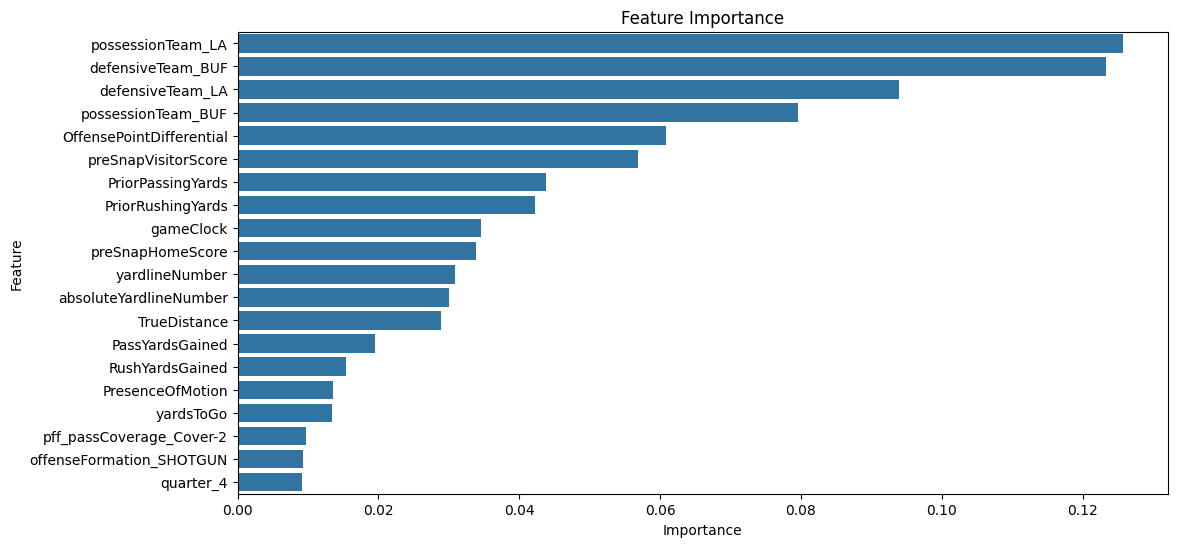

In [ ]:
#plot feature importance
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20)) #plot top 20
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

Since we ran a rf classifier, we ran the default 100 trees. This is a display of the first tree in the random forest.

In [ ]:
#Display the first tree in the rf
tree = rf_classifier.estimators_[0]
plt.figure(figsize=(100, 100))  # Adjust figure size as needed
plot_tree(tree, feature_names=feature_names, filled=True, rounded=True)
plt.show()

**How is Our Data Useful for Teams?**

The feature importance metrics can give offensive playcallers valuable insights against their opponents tendencies regarding sim pressure. These factors range from reciever formation and coverage to who the possession team is and even the time and game clock information. This can be used as a real time tool as well as in film study. Defenses could also use this information to potentially disguise their sim pressure better and make them harder to predict and recognize for offenses.